# Accumulator

The accumulator will not improve the snr of the input spike trains, but will output a cleaner signal than would otherwise have been output at the same given rates.

What about the dynamics of the accumulator? will it add an additional dynamical unit into our feedback loops?

$$
\dot{x} = u
$$

$$u=\sum_i\sum_j d_i\delta(t-t_{i,j})$$

$i$ is neuron index and $j$ is spike index

$$
x = \sum_i\sum_j d_iH(t-t_{i,j})
$$

I'd like to know when $x$ will reach threshold. It seems like that depends on the input spike rates and their respective decoding weights.

$$x=\sum_i\sum_jd_iH(t-jT_i-T_{i,0})$$

all of the input spikes are uniform but with random offsets $T_{i,0}$

That is, $T_{i,0}\sim U[0,T_i]$

In [1]:
%matplotlib inline
from acc import Pool, SpikeTrain
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from nengo.utils.matplotlib import rasterplot as nengo_raster

In [2]:
def rasterplot(spike_trains, ax=None):
    """Wrap nengo rasterplot for this notebook
    Inputs
    ------
    spike_trains: SpikeTrain or list of spike_trains
    
    Outputs
    -------
    handle of axis used to plot
    """
    if type(spike_trains) is not list:
        spike_trains = [spike_trains]
    N = len(spike_trains)
    T = []
    for n in range(N):
        T.append(len(spike_trains[n].times))
    spikes = np.zeros((np.sum(T), N+1))
    
    idx0 = 0
    for n in range(N):
        idx1 = idx0 + T[n]
        spikes[idx0:idx1, 0] = spike_trains[n].times
        spikes[idx0:idx1, n+1] = 1
        idx0 = idx1
    
    time = spikes[:,0]
    spikes = spikes[:,1:]
    
    return nengo_raster(time, spikes, ax=ax)

In [3]:
def run_experiment(N, input_rates, weights, thresheld, T=1., hist=True):
    pool = Pool(N=N, spike_rates=input_rates, weights=weights, threshold=threshold)
    spks_in = pool.gen_nrn_spikes(T=T)
    merged_spks_in = pool.merge_spikes(spks_in)
    spks_out, acc_state = pool.gen_acc_spikes(merged_spks_in)

    fig, axs = plt.subplots(nrows=3, figsize=(12,9), sharex=True)
    rasterplot(spks_out, axs[0])
    axs[1].plot(acc_state.time, acc_state.state)
    axs[1].axhline(threshold, color='r')
    rasterplot(spks_in, axs[2])
    axs[2].set_xlabel('Time')
    axs[0].set_title('Accumulator Output Spikes')
    axs[1].set_title('Accumulator State')
    axs[2].set_title('Accumulator Input Spikes')

    if hist:
        out_isi = np.diff(spks_out.times)
        fig, ax = plt.subplots(nrows=1, figsize=(8,3))
        n, bins, patches = ax.hist(out_isi, 50)
        ax.set_title('Output ISI Histogram')
        ax.set_xlabel('Time')
        ax.set_ylabel('Counts')

# Single neuron

Let's test the accumulator with a single neuron

First we consider when the neuron's weight is a multiple of the threshold

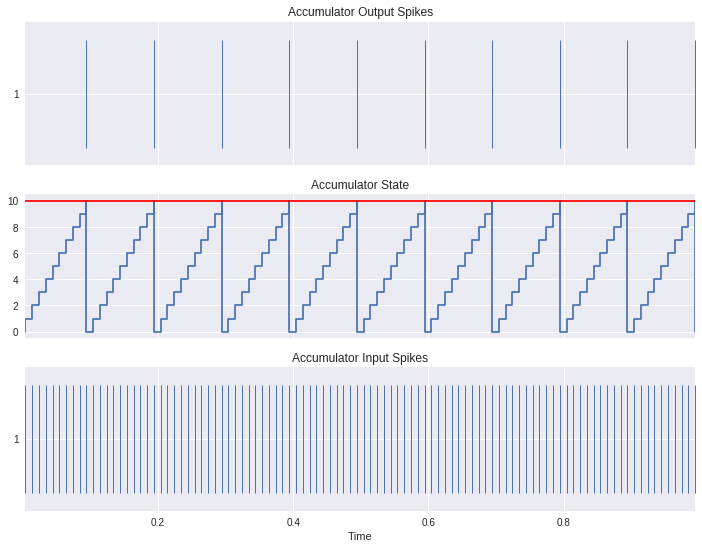

In [4]:
N = 1
input_rates = 100
weights = 1
threshold = 10
run_experiment(N=N, input_rates=input_rates, weights=weights, thresheld=threshold, hist=False)

As we expect, all of the output inter-spike intervals are the same. The accumulator simply decimates the traffic by the weight. A synapse receiving input from an accumulator would have the same statistics as one receiving input from a regularly spiking neuron of the same rate.

Next we show that an accumulator can degrade the signal quality even when controlling rate. When the neuron's weight is not a divisor of the threshold, there is variation in the output ISI.

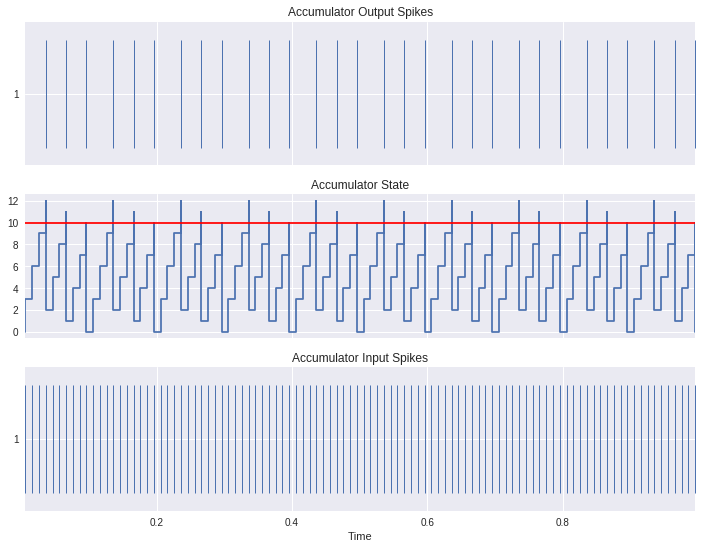

In [5]:
N = 1
input_rates = 100
weights = 3
threshold = 10
run_experiment(N=N, input_rates=input_rates, weights=weights, thresheld=threshold, hist=False)

In this case, the output ISI will be variable

# Many Neurons, Regular Spiking, Random Weights

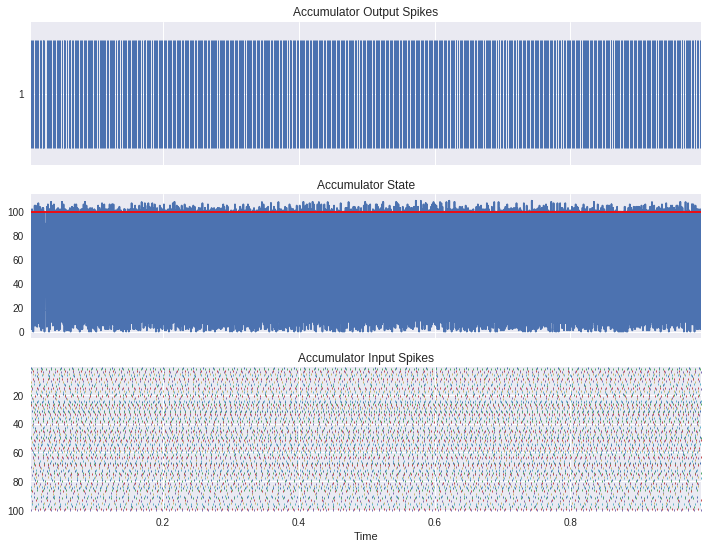

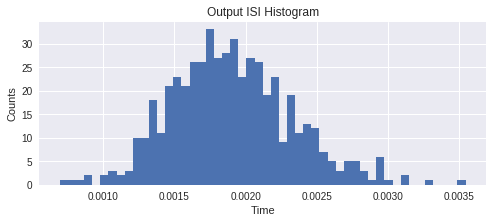

In [8]:
N = 100
input_rates = np.random.uniform(50, 150, size=N)
weights = np.random.randint(0, 11, size=N)
threshold = 100
run_experiment(N=N, input_rates=input_rates, weights=weights, thresheld=threshold)